In [1]:
from __future__ import print_function

import os, sys
import numpy as np
import pandas as pd 
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
# Utility functions for CosmoDC2Realizer
sys.path.insert(0, 'hackurdc2_utils')
import units
import moments
import cosmodc2realizer_helper as helper
import sprinkledcosmodc2realizer_helper as sprinkled_helper
# For reading in the OpSim database
import sqlite3
import healpy
# For accessing and querying the CosmoDC2 extragalactic catalog and truth catalog
import GCRCatalogs
from GCR import GCRQuery
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [39]:
# For Sprinkler
import corner
import urllib
from sklearn.cross_validation import train_test_split
#from astroML.plotting import setup_text_plots
from lsst.sims.photUtils import Sed, Bandpass, BandpassDict, getImsimFluxNorm
sys.path.insert(0, os.path.join(os.path.expanduser("~"), 'empiricisN', 'empiriciSN'))
sys.path.insert(0, os.path.join(os.path.expanduser("~"), 'XDGMM',))
sys.path.insert(0, '/global/u1/j/jwp/.local/lib/python3.6/site-packages')
import empiriciSN
import astroML
from astropy.io import fits

# Part 2: Emulating the LSST DRP Source Catalog of lensed quasar systems with SprinkledCosmoDC2Realizer

__Author:__ Ji Won Park (@jiwoncpark), __Last Run:__ 2019-02-18 (by @jiwoncpark)

__Goals:__
- In Part 1 (previous notebook in this series), we learned how CosmoDC2Realizer emulates the LSST DRP Source Catalog from galaxies in the CosmoDC2 extragalactic catalog and point sources in the truth catalog
- In Part 2 (this notebook), learn how SprinkledCosmoDC2Realizer emulates the LSST DRP Source Catalog by "sprinkling" lensed quasars from the OM10 catalog across the CosmoDC2 field, in the manner of the DC2 Sprinkler module.

The following notebook was referenced to prepare the set of lensed quasar systems to be "sprinkled": [Bryce Kalmbach's MatchingLensGalaxies.ipynb](https://github.com/LSSTDESC/Twinkles/blob/master/examples/notebooks/MatchingLensGalaxies.ipynb)

## About SprinkledCosmoDC2Realizer

SprinkledCosmoDC2Realizer combines the action of the DC2 Sprinkler, which "sprinkles" lensed quasar systems in the DC2 sky area, with that of CosmoDC2Realizer, which emulates the DRP Source and Object catalogs of such systems.  It takes in the CosmoDC2 extragalactic catalog, which contains properties of galaxy-scale lenses; the OM10 catalog (Oguri and Marshall 2010), which contains properties of simulated lensed quasar systems; and the OpSim database, which contains the per-visit observation conditions.

__Note on Terminology:__
We refer to the entire lensed quasar system, consisting of the lensing galaxy and the multiple quasar images, as a "system" for short (or sometimes "lensed system"). In our code, we also refer to the lensing galaxy as a "lens" and the quasar images as "quasars" or "qso" although they are technically multiple images of a single quasar object.

__Note on Dependencies:__

Although `SprinkledCosmoDC2Realizer` is designed as a class within an LSSTDESC package called `SLRealizer`, we do not interface with the class in this notebook. The emphasis, instead, is to go over the logic of`SprinkledCosmoDC2Realizer`. So we set aside some class helper modules in the directory `demo_utils` and use them directly.

`SprinkledCosmoDC2Realizer` does explicitly loop over each lensed system to generate the Source Catalog. But it makes heavy use of `NumPy` and `Pandas` to vectorize the moment calculation across the Gaussian components of the system, for an enhanced performance.

__Assumptions:__
- _Gaussian mixtures to allow analytical moment calculation._ Emulation is made fast by bypassing image generation; we model each object as a mixture of Gaussians and the point-spread function (PSF) as a circular Gaussian so that we can _analytically_ compute the first and second moments required to populate the Source Catalog. Because the lenses from the extragalactic catalog are modeled as Sersic profiles (de Vaucouleurs bulge and exponential disk), we approximate each Sersic component as a mixture of Gaussians as introduced in Hogg and Lang 2013 (HL13). Quasar images are modeled as point sources.
- _Quasar time variability as a damped random walk._ The light curve of each quasar is modeled as a damped random walk (DRW). A good reference is MacLeod et al 2010, which fit the DRW model to the light curves of quasars observed in the SDSS Stripe 82. They related the two DRW parameters (the damping timescale tau and the asymptotic amplitude variability SF_inf) to some physical properties of the quasars, namely the redshift, black hole mass, and luminosity. We use this relationship to infer the DRW parameters for each bandpass and generate time variability.

### A. Matching OM10 Lens Galaxies to SL2S Lens Galaxies

The DC2 Sprinkler module works by first identifying galaxies in the cosmoDC2 extragalactic catalog that are similar to lenses in OM10. If a DC2 galaxy meets a given proximity condition to an OM10 lens, we say that they are "matched." Around each matched galaxy, we "sprinkle" quasar images from the corresponding OM10 lensed system.

We seek to match with respect to size (effective radius), stellar mass, velocity dispersion, ellipticity, and redshift of the lens. But the raw OM10 catalog lacks the effective radius and stellar mass; we must first supply them using some other means.
- For the stellar mass, we fit a multivariate Gaussian model as a joint distribution over the stellar mass, velocity dispersion, and redshift of 25 lenses from SL2S (Strong Lensing in the Legacy Survey). This allows us to infer the stellar mass of each OM10 system conditioned on the velocity dispersion and redshift already available in the OM10 catalog.*
- The size did not fare well with the method, so we use the size of the matched cosmoDC2 galaxy.

The proximity condition is defined so that, quoting from Bryce's matching notebook,
>any galaxies within 10% in dex of redshift and 10% of stellar mass and ellipticity. For our lens galaxies we don't want disks. However, limiting ourselves in cosmoDC2 to only galaxies with stellar_mass_disk == 0.0 was too restrictive and we instead take the bulge properties for galaxies where the stellar mass of the bulge is over 99% of the total stellar mass. If no matches are found then it will skip on to the next system and we will leave that OM10 system out of the catalog available to the sprinkler.

*The package `empiriciSN` will be used to do the fitting and inference.

In [41]:
# Instantiate empiriciSN worker object
empiricist = empiriciSN.Empiricist()

# Read in the dataset
data_dir = os.path.join('..', 'data') # TODO: use import data
sl2s_path = os.path.join(data_dir, 'SonnenfeldEtal2013_Table3.csv')
X, Xerr = sprinkled_helper.get_sl2s_data(sl2s_path)

# Because the fit to the radius was poor, we decided to drop the radius data.
# 2 is radius
# 0, 1, 3 are z, v_disp, and log_m
X = X[:, [0, 1, 3]] 
Xerr = Xerr[:, :, [0, 1, 3]]
Xerr = Xerr[:, [0, 1, 3], :]
# Now 0, 1, 2 are z, v_disp, and log_m
# TODO maybe try to fix number indexing

# Split the dataset 65/35:
X_train, X_test, Xerr_train, Xerr_test = train_test_split(X, Xerr, test_size=0.35, random_state=17)

In [46]:
%%capture --no-stdout
# Fit model jointly over z, v_disp, log_m
model_file = 'demo_model.fit'
empiricist.fit_model(X, Xerr, filename=model_file, n_components=1)
test_sample = empiricist.XDGMM.sample(size=10000)

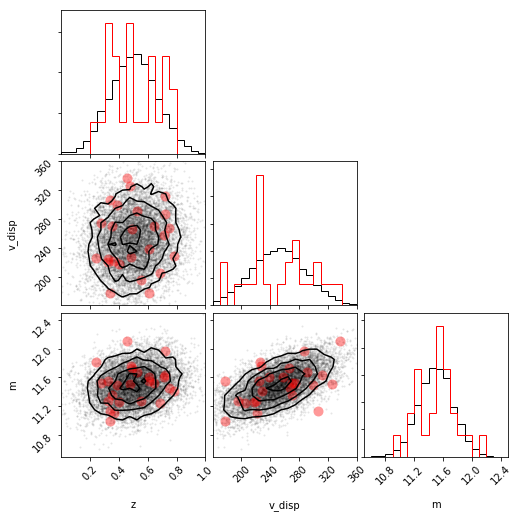

In [32]:
figure = corner.corner(test_sample[:,:], labels=['z', 'v_disp', 'm'], 
                       range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X[:, :], labels=['z', 'v_disp', 'm'], color='red', 
              range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)

plt.show()

In [36]:
%%capture --no-stdout
# Get actual masses from dataset, for comparison:
predict_idx = 2 # log_m column
log_m_test = X_test[:, predict_idx]

# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0, 1]) # condition on z, v_disp

# Populate sample log_m and r_eff
sample_log_m = np.array([])
for x, xerr in zip(X_test, Xerr_test):
    # Predict log_m
    log_m = sprinkled_helper.get_log_m(cond_indices, predict_idx, x[cond_indices], empiricist, model_file)#, Xerr=xerr)
    sample_log_m = np.append(sample_log_m, log_m)
    #print(x[3], log_m)

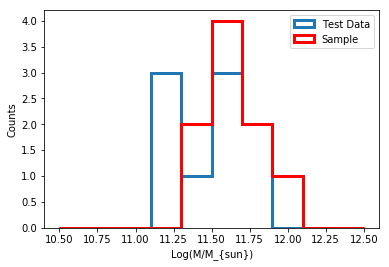

In [38]:
_, bins, _ = plt.hist(log_m_test, 10, range=(10.5, 12.5), histtype='step', lw=3)
plt.hist(sample_log_m, bins, range=(10.5, 12.5), color ='r', histtype='step', lw=3)
plt.xlabel('Log(M/M_{sun})')
plt.ylabel('Counts')
plt.legend(('Test Data', 'Sample'))
plt.show()

In [43]:
om10_path = os.path.join(data_dir, 'qso_mock.fits')
hdulist = fits.open(om10_path)
twinkles_lenses = hdulist[1].data

In [48]:
%%capture --no-stdout
# Predict a mass for each lens in OM10
np.random.seed(0)
twinkles_log_m_1comp = np.array([])
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    # Get log_m conditioned on z, v_disp
    log_m = sprinkled_helper.get_log_m(cond_indices, 2, x[cond_indices], empiricist, model_file) 
    twinkles_log_m_1comp = np.append(twinkles_log_m_1comp, log_m)

Text(0.5,1,'Predicting Masses for OM10 Lenses (1 component)')

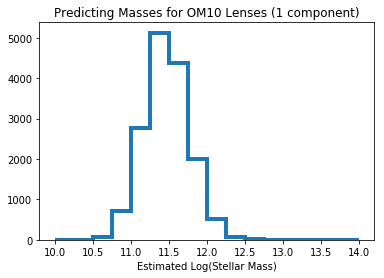

In [49]:
n, bins, _ = plt.hist(twinkles_log_m_1comp, histtype='step', label='1 component', range=(10, 14), lw=4, bins=16)
plt.xlabel('Estimated Log(Stellar Mass)')
plt.title('Predicting Masses for OM10 Lenses (1 component)')

In [50]:
# _small is a representative sample
catalog_version = 'cosmoDC2_v1.1.4'
catalog = GCRCatalogs.load_catalog(str(catalog_version + '_small'))

In [51]:
%%time
gcr_om10_match = []
err = 0
np.random.seed(10)
i = 0

z_cat_min = np.power(10, np.log10(np.min(twinkles_lenses['ZLENS'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(twinkles_lenses['ZLENS'])) + .1)

stellar_mass_cat_min = np.min(np.power(10, twinkles_log_m_1comp))*0.9
stellar_mass_cat_max = np.max(np.power(10, twinkles_log_m_1comp))*1.1

data = catalog.get_quantities(['galaxy_id', 'redshift_true', 'stellar_mass', 'ellipticity_true', 'size_true', 'size_minor_true', 
                               'stellar_mass_bulge', 'stellar_mass_disk', 'size_bulge_true', 'size_minor_bulge_true'],
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

#### Important Note
# Twinkles issue #310 (https://github.com/LSSTDESC/Twinkles/issues/310) says OM10 defines ellipticity as 1 - b/a but
# gcr_catalogs defines ellipticity as (1-b/a)/(1+b/a) (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)

data['om10_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))

data_df = pd.DataFrame(data)

CPU times: user 4.66 s, sys: 10 s, total: 14.7 s
Wall time: 1min 2s


In [52]:
%%time
gcr_om10_match = []
err = 0
np.random.seed(10)
i = 0

z_cat_min = np.power(10, np.log10(np.min(twinkles_lenses['ZLENS'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(twinkles_lenses['ZLENS'])) + .1)

stellar_mass_cat_min = np.min(np.power(10, twinkles_log_m_1comp))*0.9
stellar_mass_cat_max = np.max(np.power(10, twinkles_log_m_1comp))*1.1

data = catalog.get_quantities(['galaxy_id', 'redshift_true', 'stellar_mass', 'ellipticity_true', 'size_true', 'size_minor_true', 
                               'stellar_mass_bulge', 'stellar_mass_disk', 'size_bulge_true', 'size_minor_bulge_true'],
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

#### Important Note
# Twinkles issue #310 (https://github.com/LSSTDESC/Twinkles/issues/310) says OM10 defines ellipticity as 1 - b/a but
# gcr_catalogs defines ellipticity as (1-b/a)/(1+b/a) (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)
data['om10_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))

CPU times: user 4.38 s, sys: 10.3 s, total: 14.7 s
Wall time: 51.3 s


In [53]:
%%time
row_num = -1
keep_rows = []

for zsrc, m_star, ellip in zip(twinkles_lenses['ZLENS'], np.power(10, twinkles_log_m_1comp), twinkles_lenses['ELLIP']):

    row_num += 1
    #print(zsrc, m_star, ellip)
    if row_num % 1000 == 0:
        print(row_num)

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    m_star_min, m_star_max = m_star*.9, m_star*1.1
    ellip_min, ellip_max = ellip*.9, ellip*1.1
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f and stellar_mass > %f and stellar_mass < %f and om10_ellipticity > %f and om10_ellipticity < %f' %
                                (z_min, z_max, m_star_min, m_star_max, ellip_min, ellip_max))
    
    #data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true'])
    #data_subset = (query).filter(data)
    #print(data_subset)
    num_matches = len(data_subset['redshift_true'])
        
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift_true'].values[0], 
                    data_subset['stellar_mass_bulge'].values[0],
                    data_subset['om10_ellipticity'].values[0],
                    data_subset['size_bulge_true'].values[0],
                    data_subset['size_minor_bulge_true'].values[0],
                    data_subset['galaxy_id'].values[0]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift_true'].values[use_idx], 
                    data_subset['stellar_mass_bulge'].values[use_idx],
                    data_subset['om10_ellipticity'].values[use_idx],
                    data_subset['size_bulge_true'].values[use_idx],
                    data_subset['size_minor_bulge_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m_1comp))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
Total Match Failures:  778  Percentage Match Failures:  0.049687060927321496
CPU times: user 3min 28s, sys: 130 ms, total: 3min 28s
Wall time: 3min 29s


In [58]:
gcr_z_1comp = []
gcr_m_star_1comp = []
gcr_r_eff_1comp = []
gcr_gal_id_1comp = []
for row in gcr_om10_match:
    gcr_z_1comp.append(row[0])
    gcr_m_star_1comp.append(row[1])
    gcr_r_eff_1comp.append(np.sqrt(row[3]*row[4]))
    gcr_gal_id_1comp.append(row[5])
np.savetxt('keep_rows_agn.dat', np.array(keep_rows))

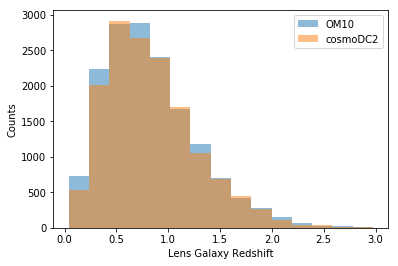

In [59]:
# Compare redshift
n, bins, p = plt.hist(twinkles_lenses['ZLENS'], alpha=0.5, bins=15, label='OM10')
plt.hist(gcr_z_1comp, alpha=0.5, bins=bins, label='cosmoDC2')
plt.xlabel('Lens Galaxy Redshift')
plt.ylabel('Counts')
plt.legend()

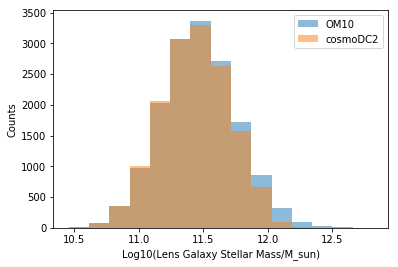

In [62]:
# Compare stellar mass
n, bins, p = plt.hist(twinkles_log_m_1comp, alpha=0.5, bins=15, label='OM10')#, range=(0,100))
plt.hist(np.log10(gcr_m_star_1comp), alpha=0.5, bins=bins, label='cosmoDC2')
plt.xlabel('Log10(Lens Galaxy Stellar Mass/M_sun)')
plt.ylabel('Counts')
plt.legend()